# TDA  with Python using the Gudhi Library 

# Representing sublevel sets of functions using cubical complexes 

**Author**  : B. Michel

In [2]:
import numpy as np
import gudhi as gd  
import pickle as pickle
from pylab import *
from sklearn.neighbors import KernelDensity
import seaborn as sns
import math

In [3]:
def generate_circle(n, radius, max_noise):
    """
    Generate n points on a sphere with the center in the point (0,0) 
    with the given radius. 
    
    Noise is added so that the distance from
    the generated point to some point on the sphere does not
    exceed max_noise parameter.
    
    Returns the list of generated points.    
    """
    points = []
    for i in range(n):
        angle = 2 * math.pi * random()
        noise = max_noise * random()
        r = radius * (1 + noise)
        point = [r * math.cos(angle), r * math.sin(angle)]
        points.append(point)
    return np.array(points)
def generate_torus_points(R, r, num_points):
    theta = np.linspace(0, 2 * np.pi, num_points)
    phi = np.linspace(0, 2 * np.pi, num_points)
    theta, phi = np.meshgrid(theta, phi)

    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)

    return np.transpose([x.flatten(),y.flatten(),z.flatten()])

TDA signatures can be extracted from the upper level or sublevel sets of a function  $f :\mathbb R^p \mapsto \mathbb R$. 

One possible approach for studying the topology of the sublevel sets of $f$ is to define a regular grid on $R^d$ and then a filtered complex with vertices located on this grid, with $f$ as filtration function. Such a grid-based filtered complex is called a **cubical complexes** in Gudhi. See the [documentation](https://gudhi.inria.fr/python/latest/cubical_complex_user.html) of its constructor.

### Crater dataset

We use the crater dataset to illustrate cubical complex filtrations:

In [4]:
f = open("./crater_tuto", "rb")
crater = pickle.load(f)
f.close()

The point cloud is in $\mathbb R^2$ and is composed of a central annulus and four clusters at the corners:

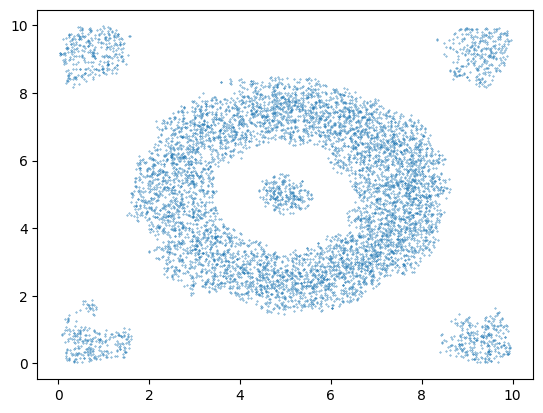

In [5]:
plt.scatter(crater[:, 0], crater[:, 1], s = 0.1);

Instead of directly defining a Vietoris-Rips complex or an alpha complex on the point cloud, we want to study the upper level sets of a density estimator computed on the point cloud. 

We can  visualize the estimated density with a standard 2d-kernel estimator with the `seaborn` module:

In [4]:
def createWeirdTorus():
    space = np.zeros((5,5,5))
    space[:, 2, 2] = 1
    return space

def getPointsFromSpace(space):
    # mora bit 3D
    xval, yval, zval = np.shape(space)
    points = [[u, v, z] for u in range(xval) for v in range(yval) for z in range(zval)]
    filts = [space[u, v, z] for u in range(xval) for v in range(yval) for z in range(zval)]
    return np.array(points), np.array(filts)

In [18]:
# crater = generate_circle(100, 5, 0)
crater = generate_torus_points(3, 2, 30)
# crater = np.array([[u, v] for u in range(50) for v in range(50)])
# crater = np.array([[0,0,0], [0,1,0], [0,2,0], [1,0,0], [1,2,0], [2,0,0], [2,1,0], [2,2,0],
#                    [0,0,1], [0,1,1], [0,2,1], [1,0,1], [1,2,1], [2,0,1], [2,1,1], [2,2,1],
#                    [0,0,2], [0,1,2], [0,2,2], [1,0,2], [1,2,2], [2,0,2], [2,1,2], [2,2,2]])
# periodic_dimensions = np.zeros((len(crater)))
# periodic_dimensions[:7] = 1
# periodic_dimensions[16:] = 1
space = createWeirdTorus()
points, filts = getPointsFromSpace(space)
periodic = [1,0,0]

In [10]:
pointsDeleted = np.delete(points, [12, 12+25, 12+50,12+75,112], axis = 0)
# print(pointsDeleted)

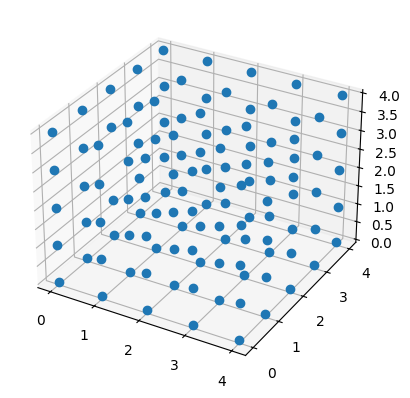

In [104]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D curve
ax.plot(pointsDeleted[:, 0], pointsDeleted[:, 1], pointsDeleted[:, 2], label='3D curve', marker = "o", ls = "")
plt.show()

/tmp/ipykernel_94066/2282867271.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


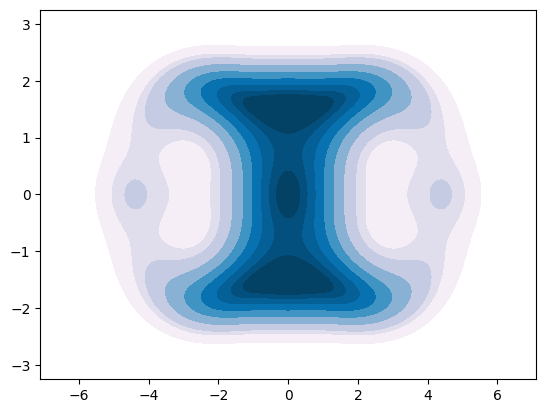

In [6]:
sns.kdeplot(
    x = crater[:, 1], 
    y = crater[:, 2], 
    shade = True, 
    cmap = "PuBu", 
    bw_method = .3
);

### Cubical complex for the crater dataset

We first define a regular grid on $[0,10] \times [0,10]$.

In [11]:
xval = np.arange(0, 6, 1)
yval = np.arange(0, 6, 1)
zval = np.arange(0, 6, 1)
nx = len(xval)
ny = len(yval)
nz = len(zval)

In [94]:
print(xval)

[0 1]


Next we fit a $2$-dimensional standard kernel density estimator on the data using `scikit-learn`:

In [12]:
kde = KernelDensity(kernel = 'gaussian', bandwidth = 0.3).fit(pointsDeleted)
positions = np.array([[u, v, z] for u in xval for v in yval for z in zval])
# print(positions)

In [59]:
print(kde)

KernelDensity(bandwidth=0.3)


The cubical complex filtration considers the sublevel sets of the filtration fonction. For studying the upper level sets of the density we need to take the opposite of the KDE. We define the filtration value  at each vertex as follows:

In [13]:
filt_values = -kde.score_samples(X = positions)

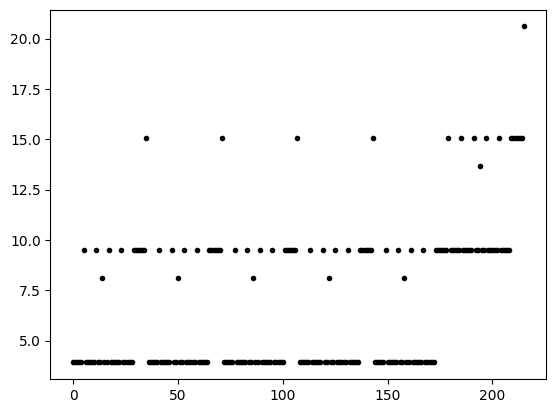

In [14]:
# print(filt_values)
plt.plot(filt_values, "k.")

The range of filtration values is :

In [105]:
print(min(filt_values), max(filt_values))

0.590499147288601 2.174519894934215


Note that the filtration values are positive because the `score_samples()` method of the `KernelDensity` class returns the log-density which is, by definition, always negative.

We are now all set to compute the cubical complex filtration based on the grid `[xval, yval]` using the values stored in `filt_values` as filtration values:

In [20]:
cc_density_crater = gd.PeriodicCubicalComplex(
    dimensions = np.shape(space), 
    top_dimensional_cells = filts,
    periodic_dimensions = periodic
)

Note that a cubical complex is not a simplex tree object:

In [62]:
type(cc_density_crater)

gudhi.cubical_complex.CubicalComplex

However the class `CubicalComplex` has similar methods:

In [63]:
cc_density_crater.dimension()

2

In [39]:
cc_density_crater.num_simplices()

25921

In [21]:
persistence = cc_density_crater.persistence()
for p in persistence:
    print(p)

(1, (0.0, inf))
(1, (0.0, 1.0))
(0, (0.0, inf))


inf


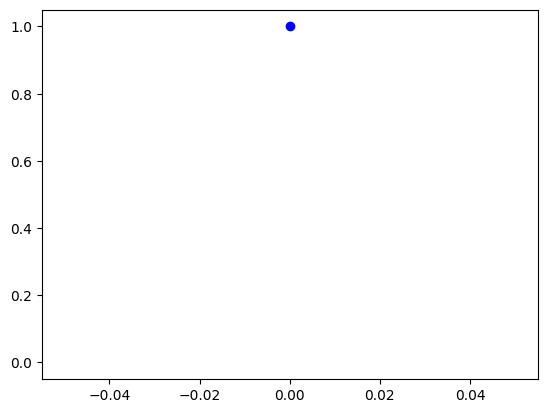

In [22]:
dim = 1
points = []
for p in persistence:
    if p[0] == dim:
        if p[1][1] == float("inf"):
            print("inf")
        points.append(p[1])

points = np.array(points)
x = np.linspace(0, np.max(points[:,0]))
plt.plot(points[:,0], points[:, 1], "bo")
plt.plot(x,x)


### Problem cikličnosti x. 

In [144]:
space = np.ones((4,4))
space[0:2, 1] = 0
space[2:, 2] = 0
# space[0, 1:3] = 0
# space[3, 1:3] = 0
# space[3:, 0] = 0

In [84]:
import matplotlib.patches as patches
def getSquareCoordinates(space):
    y, x = np.shape(space)
    points = []
    for i in range(x):
        for j in range(y):
            if space[j][i] == 0:
                points.append([i, j])
    return np.array(points)

def getSquarePoints(x0y0):
    x = np.array([0, 1])
    y = np.array([1, 0])
    return np.array([x0y0, x0y0 + x, x0y0+y+x, x0y0+y])

def draw_square(ax, coord, size = 1):
    coord = getSquarePoints(coord)
    # coords = np.append(coord, [coord[0]], axis = 0)
    ax.fill_between(coord[:,0], coord[:,1], color = "b")

def plotSquares(coordsList):
    fig, ax = plt.subplots()

    for coord in coordsList:
        square = patches.Rectangle(coord, 1, 1, edgecolor='none', facecolor='blue', alpha=0.5, label='Filled Square')
        ax.add_patch(square)
    ax.set_xlim(0, np.max(coordsList[:,0]+1))
    ax.set_ylim(0, np.max(coordsList[:,1]+1))

    plt.show()

In [145]:
print(space)

[[1. 0. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [1. 1. 0. 1.]]


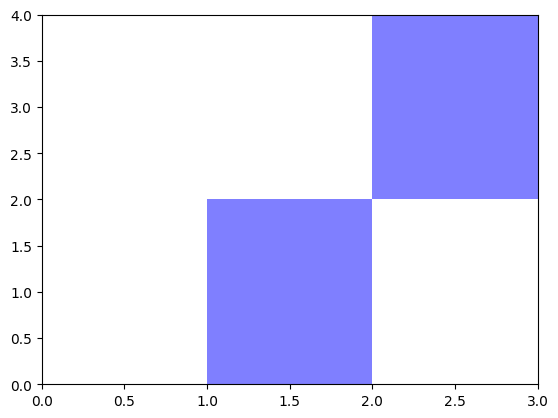

In [146]:
plotSquares(getSquareCoordinates(space))

In [150]:
filts = np.ravel(space)*5+0.5
cc_density_crater = gd.PeriodicCubicalComplex(
    dimensions = np.shape(space), 
    top_dimensional_cells = filts,
    periodic_dimensions = [0,1] # periodično v z dimenziji
)
persistence = cc_density_crater.persistence()
for p in persistence:
    print(p)

(1, (0.5, inf))
(0, (0.5, inf))
